In [ ]:
import math
import numpy as np
import collections
from torch.utils import data

import sys
sys.path.append('.')
sys.path.append('../')
sys.path.append("/Users/antonis/projects/slab/neuroformer/neuroformer")
from einops import rearrange

import torch
import torch.nn as nn
from torch.nn import functional as FeatureAlphaDropout
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from scipy import io as scipyio
import skimage
import skvideo.io
from utils import print_full

import os
import glob
parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"

In [ ]:
from utils import set_seed
set_seed(25)

In [ ]:
# R3D: (3 x T x H x W)

from SpikeVidUtils import image_dataset

im_path = ['/Combined Stimuli 3-grating.tif',
           '/Combined Stimuli 3-Movie2.tif',
           '/Combined Stimuli 3-Movie3.tif']

train_path = "/content/stimulus"
train_path = "/Users/antonis/projects/slab/neuroformer/OneCombo3/stimuli"
video_stack = [skimage.io.imread(train_path + vid) for vid in im_path]
print(glob.glob(train_path + '/*.tif'))
video_stack = np.concatenate(video_stack, axis=0)

# video_stack = skimage.io.imread("/home/antonis/projects/slab/git/slab/transformer_exp/code/data/OneCombo3/stimuli/Combined Stimuli 3-grating.tif")
# video_stack = image_dataset(video_stack)
# video_stack = video_stack[::3]  # convert from 60 to 20 fps
# video_stack = video_stack.view(1, video_stack.shape[0], video_stack.shape[1], video_stack.shape[2], video_stack.shape[3])

video_stack = image_dataset(video_stack)
video_stack = video_stack[::3]  # convert from 60 to 20 fps
video_stack = video_stack.view(3, video_stack.shape[0] // 3, video_stack.shape[1], video_stack.shape[2], video_stack.shape[3])
# video_stack = video_stack.transpose(-1, -2)

# rearrange(video_stack[0, 0:2].transpose(0,1), 'c t (h p1) (w p2) -> (t h w) (p1 p2 c)', p1=16, p2=16).shape

In [ ]:
plt.figure()
plt.imshow(video_stack[0, 1].permute(1, 2, 0))
plt.figure()
plt.imshow(video_stack[1, 1].permute(1, 2, 0))
plt.figure()
plt.imshow(video_stack[2, 1].permute(1, 2, 0))

In [ ]:
# spike_path = "/home/antonis/projects/slab/git/slab/transformer_exp/code/data/SImNew3D/neural/NatureMoviePart1-A" # "code/data/SImIm/simNeu_3D_WithNorm__Combo3.mat" 
from SpikeVidUtils import trial_df_combo3

spike_data = scipyio.loadmat("/Users/antonis/projects/slab/neuroformer/OneCombo3/spiketrain.mat")
spike_data = np.squeeze(spike_data['spiketrain'].T, axis=-1)
spike_data = [trial_df_combo3(spike_data, n_stim) for n_stim in range(3)]
spike_data = pd.concat(spike_data, axis=0)

spike_data['Trial'] = spike_data['Trial'] + 1
spike_data['Time'] = spike_data['Time'] * 0.0751
spike_data = spike_data[(spike_data['Time'] > 0) & (spike_data['Time'] <= 32)]

# vid_duration = [len(vid) * 1/20 for vid in vid_list]

df = spike_data
del spike_data

In [ ]:
# df = pd.read_csv(parent_path + "code/data/OneCombo3/Combo3_all_stim.csv")
window = 0.5
dt = 0.05

from SpikeVidUtils import make_intervals

df['Interval'] = make_intervals(df, window)
df['Interval_dt'] = make_intervals(df, dt)
df['Interval_dt'] = (df['Interval_dt'] - df['Interval'] + window).round(3)
df = df.reset_index(drop=True)

In [ ]:
# n_dt = sorted((df['Interval_dt'].unique()).round(2)) 
dt_range = int(window / dt) + 2  # add first / last interval for SOS / EOS'
n_dt = [round(dt * n, 2) for n in range(int(window / dt) + 2)]
df['Time'] = df['Time'].round(3)

In [ ]:
n = []
for n_stim in range(3):
    n_trial = [3, 15, 5, 18]
    for n_trial in n_trial:
        trial = (n_stim + 1) * 20 - n_trial
        n.append(trial)
train_data = df[~df['Trial'].isin(n)].reset_index(drop=True)
test_data = df[df['Trial'].isin(n)].reset_index(drop=True)
small_data = df[df['Trial'].isin([5])].reset_index(drop=True)

In [ ]:
from utils import set_plot_params

set_plot_params()

In [297]:
# df_pred = pd.read_csv("/Users/antonis/projects/slab/neuroformer/OneCombo3/inference/model_weighted_shuffle_decay_True_perceiver_2.0_dt_0.05_eos_8_8_256.csv").iloc[:, 1:]
df_pred = pd.read_csv("OneCombo3/inference/model_weighted_shuffle:True_perceiver_2.0_dt:0.05_eos_8_8_256.csv").iloc[:, 1:]
# df_pred['Trial'] = test_data['Trial']
df_pred.rename({'id':'ID', 'trial':'Trial', 'interval':'Interval', 'time':'Time'}, axis=1, inplace=True)
df_pred.head()


,ID,Time,Trial,Interval
0,0,0.00,0,0.0
1,128,0.20,2,0.5
2,13,0.45,2,0.5
3,166,0.55,2,0.5
4,104,0.05,2,1.0


In [298]:
df_pred['dt'] = df_pred['Time']
df_pred['Time'] = df_pred['dt'] + df_pred['Interval'] - 0.5

In [299]:
df_1 = test_data
df_2 = df_pred

In [300]:
df_1 = df[df['Trial'] == 15]
df_2 = df[df['Trial'] == 16]

<BarContainer object of 80 artists>

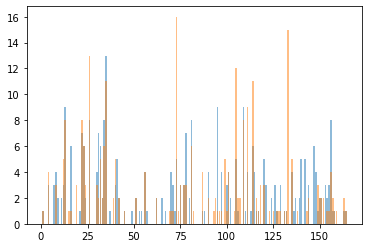

In [301]:
# def plot_this(true_df, predicted_df):
#     plt.figure(figsize=(30,20))
#     n_min = 165
#     freq_true = true_df[true_df[0] < n_min].groupby([0]).size()
#     print(freq_true)
#     freq_pred = predicted_df[predicted_df[0] < n_min].groupby([0]).size()
#     plt.bar(freq_pred.index, freq_pred, label='predicted', alpha=0.5)
#     plt.bar(freq_true.index, freq_true, label='true', alpha=0.5)
#     plt.title('Neuron Firing Distribution (PSTH Loss)', fontsize=40)
#     plt.legend(fontsize=30)
#     plt.show()

df_15_freq = df_1.groupby(['ID']).size()
df_16_freq = df_2.groupby(['ID']).size()

plt.bar(df_15_freq.index, df_15_freq, label='predicted', alpha=0.5)
plt.bar(df_16_freq.index, df_16_freq, label='true', alpha=0.5)

In [302]:
# labels = [round(window + window*n, 2) for n in range(0, int(max(df_pred['Time']) / window))]

# def group_intervals(df, dt):
#     window = dt
#     bins = int(max(df['Time']) / window)
#     intervals = pd.cut(df['Time'], bins=int(max(df['Time']) / window))
#     labels = [round(window + window*n, 2) for n in range(0, int(max(df['Time']) / window))]
#     indexes = [n for n in range(0, int(max(df['Time']) / window))]
#     df['Interval'] = pd.cut(df['Time'], bins=int(max(df['Time']) / window), labels=labels).astype('float32')
#     df['Interval_idx'] = pd.cut(df['Time'], bins=int(max(df['Time']) / window), labels=indexes)
#     df = df.reset_index().drop(['index'], axis=1)
#     return df

# df_pred = group_intervals(df_pred, window)

labels = [round(window + window*n, 2) for n in range(0, int(max(df['Interval']) / window))]

In [303]:
def get_rates(df, intervals):
    df_true = df.groupby(['True', 'Interval']).count().unstack(fill_value=0).stack()['Predicted']
    df_pred = df.groupby(['Predicted', 'Interval']).count().unstack(fill_value=0).stack()['True']
    def set_rates(df, id, intervals):
        df = df[id]
        rates = np.zeros_like(intervals)
        for i in df.index:
            n = int((i * 2) - 1)
            rates[n] = df[i]            
        return rates
    rates_true = dict()
    rates_pred = dict()
    for id in list(set(df['True'].unique()) & set(df['Predicted'].unique())):
        rates_true[id] = set_rates(df_true, id, intervals)
        rates_pred[id] = set_rates(df_pred, id, intervals)
    return rates_true, rates_pred

In [304]:
def get_rates(df, ids, intervals):
    df = df.groupby(['ID', 'Interval']).count().unstack(fill_value=0).stack()['Time']
    def set_rates(df, id, intervals):
        rates = np.zeros_like(intervals)
        if id not in df.index:
            return rates
        else:
            df = df[id]
            for i in df.index:
                n = int((i * 2) - 1)
                rates[n] = df[i]            
            return rates
    rates = dict()
    for id in ids:
        rates[id] = set_rates(df, id, intervals)
    return rates

ids = list(set(df_1['ID'].unique()) & set(df_2['ID'].unique()))
rates_1 = get_rates(df_1, ids, labels)
rates_2 = get_rates(df_2, ids, labels)

In [109]:
from scipy import stats
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
from scipy.special import kl_div

def calc_corr_psth(rates1, rates2):
    pearson_r = dict()
    for id in list((set(rates1.keys()) & set(rates2.keys()))):
        pearson_r[id] = stats.pearsonr(rates1[id], rates2[id])[0]
    # pearson_r = dict(sorted(pearson_r.items(), reverse=True, key=lambda item: item[1]))
    pearson_r = pd.DataFrame(pearson_r, index=['pearson_r']).T.sort_values(by=['pearson_r'], ascending=False)
    return pearson_r


top_corr = calc_corr_psth(rates_1, rates_2)

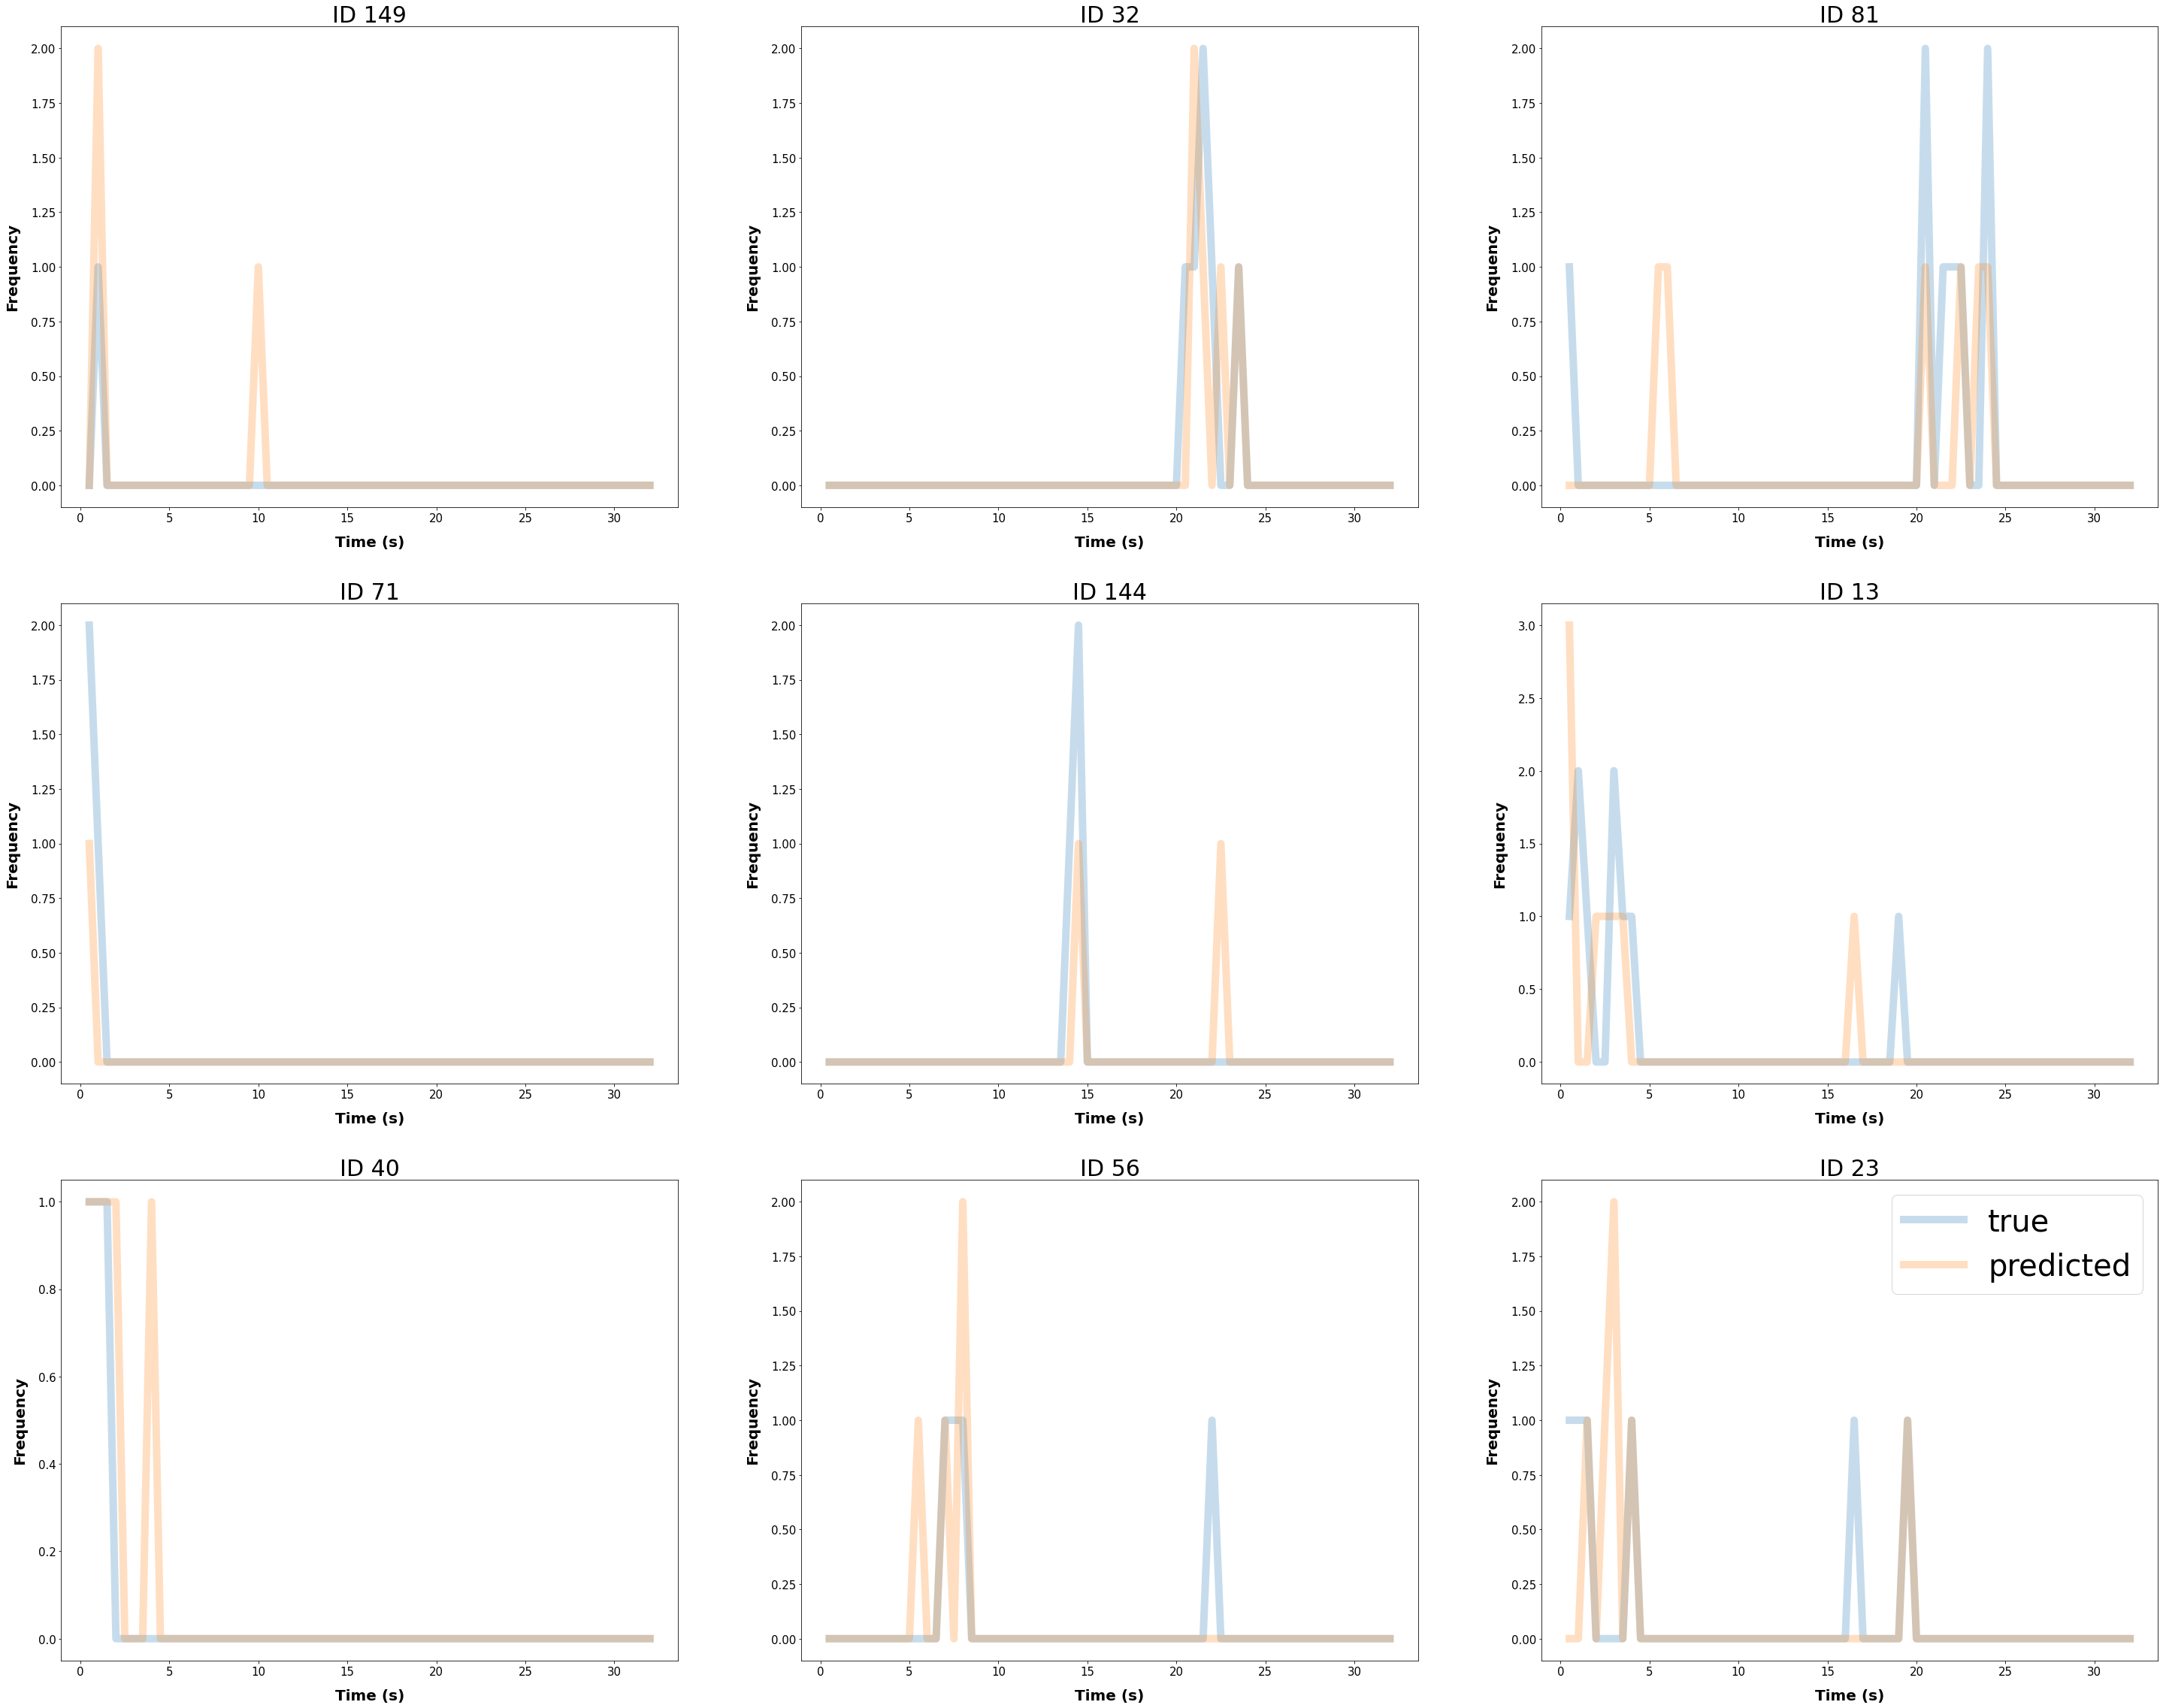

In [110]:
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.labelpad'] = 15

cols = 3
rows = 3
plt.figure(figsize=(50, 40))
plt.title('Neuron Firings', size=20)
gs = plt.GridSpec(cols, rows)
for n, id in enumerate(top_corr.index[:cols*rows]):
    i = n % cols
    j = n // cols
    plt.subplot(gs[i, j])
    plt.plot(labels, rates_1[id], alpha=0.25, label='true', linewidth=10)
    plt.plot(labels, rates_2[id], alpha=0.25, label='predicted', linewidth=10)
    plt.title(f'ID {id}', size=30)
    plt.ylabel('Frequency', size=20)
    plt.xlabel('Time (s)', size=20)

plt.legend(fontsize=40)

In [111]:
def get_rates_trial(df, intervals):
    df_rates = df.groupby(['ID', 'Interval']).count().unstack(fill_value=0).stack()
    def set_rates(df, id, intervals):
        df = df.loc[id]
        rates = np.zeros_like(intervals)
        for i in df.index:
            n = int((i * 2) - 2)
            rates[n] = df['Time'].loc[i] 
        return rates
    rates = dict()
    for id in list(set(df['ID'].unique())):
        rates_id = set_rates(df_rates, id, intervals)
        rates[id] = rates_id
    return rates

In [112]:
t_1 = 25
t_2 = 35

rates_trial_8 = get_rates_trial(df[df['Trial'] == t_1].reset_index(drop=True), labels)
rates_trial_1 = get_rates_trial(df[df['Trial'] == t_2].reset_index(drop=True), labels)
corr_trials = calc_corr_psth(rates_trial_1, rates_trial_8)

# neuron_list = [5 * n for n in range(10)]
# neuron_list = [5 * n for n in range(10)]
# neuron_list = df_pred.groupby(['True']).size().nlargest(20).index.tolist()
# neuron_list = top_corr[:20].index.tolist()

# df_pred_8_true = df_pred.iloc[test_data[test_data['Trial'] == t_1].index.tolist()][df_pred['True'].isin(neuron_list)]
# df_pred_8_pred = df_pred.iloc[test_data[test_data['Trial'] == t_1].index.tolist()][df_pred['Predicted'].isin(neuron_list)]
# df_pred_7_true = df_pred.iloc[test_data[test_data['Trial'] == t_2].index.tolist()][df_pred['True'].isin(neuron_list)]

# df_pred_8_true['Time'] -= df_pred_8_true['Time'].max()
# df_pred_8_pred['Time'] -= df_pred_8_pred['Time'].max()
# df_pred_7_true['Time'] -= df_pred_7_true['Time'].max()

# df_pred_8_true_= pd.melt(df_pred_8_true, id_vars='Time', value_vars=['True']).dropna()
# df_pred_8_pred_= pd.melt(df_pred_8_pred, id_vars='Time', value_vars=['Predicted']).dropna()
# df_pred_7_true_ = pd.melt(df_pred_7_true, id_vars='Time', value_vars=['True']).dropna()

In [113]:
def get_spikes(df_pred, df, trial, neuron_list, labels):
    rates_trial = get_rates_trial(get_rates_trial(df[df['Trial'] == trial].reset_index(drop=True), labels))
    df_pred_true = df_pred.iloc[test_data[test_data['Trial'] == trial].index.tolist()][df_pred['True'].isin(neuron_list)]
    df_pred_pred = df_pred.iloc[test_data[test_data['Trial'] == trial].index.tolist()][df_pred['Predicted'].isin(neuron_list)]
    return df_pred_true, df_pred_pred


In [114]:
# neuron_list = top_corr[:20].index.tolist()
# spacing = np.arange(0, 250, step=250/len(neuron_list))
# for ix, neuron in enumerate(df_pred_8_true['True'].unique()):
#     df_pred_8_true['True'][df_pred_8_true['True'] == neuron] = spacing[ix]
#     df_pred_8_pred['Predicted'][df_pred_8_pred['Predicted'] == neuron] = spacing[ix]
#     df_pred_7_true['True'][df_pred_7_true['True'] == neuron] = spacing[ix]

In [115]:
# def plot_neurons_trials(df, neurons, trials):
#     for n in trials:
#         df = df[df['ID'].isin(neurons) & (df['Trial'] == n)]
#         plt.scatter(test_data_idn_1['Time'], test_data_idn_1['ID'], color='#b3e045', marker="|", s=100, label='Real')


In [116]:
# def grouopby_reindex(df):
#     df = df.set_index('Time').groupby('ID', as_index=False)\
#         .apply(lambda x: x.reindex(df.Time.unique()))\
#         .sort_index().reset_index([1])
    
#     df.ID = df.groupby(level=0).user_id.transform(lambda x: x.ffill().bfill())
#     df['count'] = df['count'].fillna(0)

#     return df

# grouopby_reindex(df_p[df_p['Trial'] == 2])

In [117]:
def label_data(data):
    data['label'] = pd.Categorical(data['ID'], ordered=True).codes
    return data

label_data(test_data_idn_2)

,Time,ID,Trial,Interval,Interval_dt,label
0,0.331,71,5,0.5,0.35,6
1,0.944,22,5,1.0,0.45,3
2,3.091,23,5,3.5,0.10,4
3,3.185,13,5,3.5,0.20,0
4,4.200,22,5,4.5,0.20,3
5,4.248,22,5,4.5,0.25,3
6,4.524,13,5,5.0,0.05,0
7,6.502,22,5,7.0,0.05,3
8,8.585,22,5,9.0,0.10,3
9,12.881,22,5,13.0,0.40,3


In [118]:
df_p = df_pred
# df_p['ID'] = df_p['ID'].astype('category').cat.codes

In [119]:
df_p['ID']

0         0
1        75
2       104
3       156
4       159
       ... 
5556      6
5557     11
5558    116
5559     68
5560    126
Name: ID, Length: 5561, dtype: int64

In [ ]:
neuron_list = list(map(str, sorted(top_corr[:10].index.tolist())))
# neuron_list = sorted(top_corr[:10].index.tolist())
trials = 17, 5

df_pred['ID'] = df_pred['ID'].astype('str')
test_data['ID'] = test_data['ID'].astype('str')

df_pred_idn = df_pred[df_pred['ID'].isin(neuron_list) & df_pred['Trial'].isin(trials)].reset_index(drop=True)
test_data_idn_1 = test_data[test_data['ID'].isin(neuron_list) & test_data['Trial'].isin([trials[0]])].reset_index(drop=True)
test_data_idn_2 = test_data[test_data['ID'].isin(neuron_list) & test_data['Trial'].isin([trials[1]])].reset_index(drop=True)

# offset = 0.5
# test_data_idn_1['ID'] += offset
# test_data_idn_2['ID'] -= offset

# df_pred_idn['ID'] = df_pred_idn['ID'].astype('str')
# test_data_idn_1['ID'] = test_data_idn_1['ID'].astype('str')
# test_data_idn_2['ID'] = test_data_idn_2['ID'].astype('str')

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(df_pred_idn['Time'], df_pred_idn['ID'], color='#45b3e0', marker="|", s=100, label='Simulated')
ax.scatter(test_data_idn_1['Time'], test_data_idn_1['ID'], color='#b3e045', marker="|", s=100, label=f'Trial {trials[0]}')
ax.scatter(test_data_idn_2['Time'], test_data_idn_2['ID'], color='#e045b3', marker="|", s=100, label=f'Trial {trials[1]}')

plt.legend(fontsize=20)

In [ ]:
def plot_neurons(ax, df, neurons):
    for id in neurons:
        data = df[df['ID'] == id]
        data_id = data['ID'][data['ID'] == id]
        color = color_map[id]
        ax.scatter(data['Time'], data_id, color=color, marker="|", s=150, label='Simulated')
        
        # ax.set_ylim(0, len(neurons))
        xlim = int(max(df['Interval']))
        ax.set_xlim(0, xlim)
        ax.set_xticks(np.linspace(0, xlim, num=3))
        
        ax.tick_params(axis='y', labelsize=15) 
        ax.tick_params(axis='x', labelsize=15)  

df_pred['ID'] = df_pred['ID'].astype('int')
test_data['ID'] = test_data['ID'].astype('int')      

neuron_list = list(map(str, sorted(top_corr[:5].index.tolist())))
neuron_list = list(map(int, [i for i in range(20, 26)]))

color_labels = neuron_list
rgb_values = sns.color_palette("bright", len(neuron_list))
color_map = dict(zip(color_labels, rgb_values))


trials = test_data['Trial'].unique()[:4]
fig, ax = plt.subplots(nrows=len(trials), ncols=2, figsize=(12,10))

for n, trial in enumerate(trials):
    true_df = test_data[test_data['Trial'] == trial]
    pred_df = df_pred[df_pred['Trial'] == trial]
    ax[n][0].set_ylabel(f'Trial {trial}')
    plot_neurons(ax[n][0], true_df, neuron_list)
    plot_neurons(ax[n][1], pred_df, neuron_list)

    # ax[0][n].get_shared_x_axes().join(ax[0][0], ax[0][n])
    # ax[1][n].get_shared_x_axes().join(ax[0][0], ax[1][n])


plt.setp(ax, yticks=neuron_list, yticklabels=neuron_list)

ax[0][0].set_title('True')
ax[0][1].set_title('Predicted')

fig.supxlabel('Time (S)')
fig.supylabel('Neuron ID')

plt.tight_layout()

plt.savefig('/Users/antonis/projects/slab/neuroformer/plots/neuron_pred_true.png', dpi=300)

# ax[0].scatter(df_pred_idn['Time'], df_pred_idn['ID'], color='#45b3e0', marker="|", s=100, label='Simulated')
# ax[1].scatter(test_data_idn_1['Time'], test_data_idn_1['ID'], color='#b3e045', marker="|", s=100, label=f'Trial {trials[0]}')

In [ ]:
color_map

In [ ]:
from utils import *

set_plot_white()

def get_freqs(df, n_neurons):
    freqs = np.zeros(n_neurons)
    for i in range(n_neurons):
        freqs[i] = (len(df[df['ID'] == i]))
    return freqs

true_color = "#069AF3"
pred_color = "#F97306"
train_color = "#008000"


df_pred = df_pred[df_pred['ID'] <= max(test_data['ID'].unique())]

n_trials = 5
n_neurons = len(train_data['ID'].unique())
fig, ax = plt.subplots(figsize=(10, 20), nrows=n_trials, ncols=2)

common_trials = df_pred['Trial'].unique().tolist()
common_trials.remove(2)
for i in range(n_trials):
    chosen_trial = np.random.choice(common_trials)
    freq_true = get_freqs(test_data[test_data['Trial'] == chosen_trial], n_neurons)
    freq_pred = get_freqs(df_pred[df_pred['Trial'] == chosen_trial], n_neurons)
    freq_train = get_freqs(train_data[train_data['Trial'] == chosen_trial + 1], n_neurons)

    ax[i, 0].set_title(f"True vs. Predicted, {chosen_trial}")
    ax[i, 0].scatter(freq_true, freq_pred, alpha=0.5, color=pred_color)
    ax[i, 0].set_xlim(0, max(freq_pred + freq_true))
    ax[i, 0].set_ylim(0, max(freq_pred + freq_true))

    ax[i, 1].set_title(f"True vs. True, {chosen_trial} - {chosen_trial + 1}")
    ax[i, 1].scatter(freq_true, freq_train, alpha=0.5, color=true_color)
    ax[i, 1].set_xlim(0, max(freq_train + freq_true))
    ax[i, 1].set_ylim(0, max(freq_train + freq_true))

    common_trials.remove(chosen_trial)


fig.supxlabel('Count (N)')
fig.supylabel('Count (N)')
fig.suptitle("Trial ID Frequency Comparison", y=0.92, fontsize=16)
plt.tight_layout

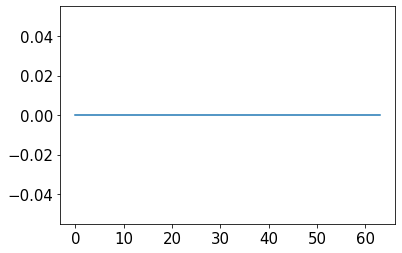

In [56]:
plt.plot(get_rates(df_pred, [125], labels)[125])

In [237]:
# for i in df_pred.groupby('ID').size().nlargest(10).index:
#     print(i)

In [266]:
def get_id_intervals(df, n_id, intervals):
    id_intervals = np.zeros(len(intervals))
    interval_counts = df[df['ID'] == n_id].groupby(df['Interval']).size()
    id_intervals[interval_counts.index.astype(int).tolist()] = interval_counts.index.astype(int).tolist()
    return id_intervals.tolist()

# get_id_intervals(df_pred, 30, labels)

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

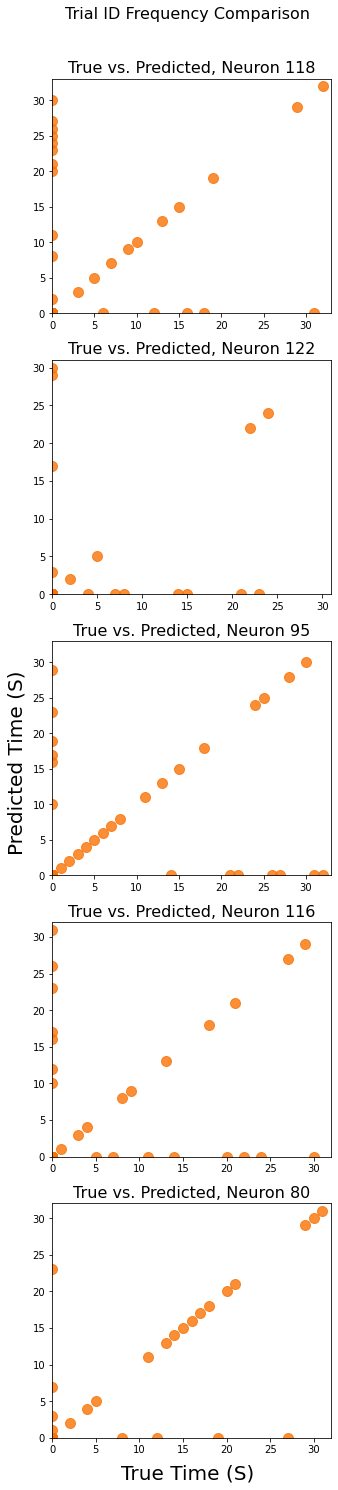

In [322]:
from utils import *

set_plot_white()

df_pred['ID'] = df_pred['ID'].astype(int)
test_data['ID'] = test_data['ID'].astype(int)

def get_id_intervals(df, n_id, intervals):
    id_intervals = np.zeros(len(intervals))
    interval_counts = df[df['ID'] == n_id].groupby(df['Interval']).size()
    id_intervals[interval_counts.index.astype(int).tolist()] = interval_counts.index.astype(int).tolist()
    return id_intervals.tolist()

rates_true, rates_pred = get_rates(test_data, ids, labels), get_rates(df_pred, ids, labels)
top_corr = calc_corr_psth(rates_true, rates_pred)

true_color = "#069AF3"
pred_color = "#F97306"
train_color = "#008000"

df_pred = df_pred[df_pred['ID'] <= max(test_data['ID'].unique())]

# neuron_ids = [i for i in range(20, 26)]
# neuron_ids = top_corr[:5]
# neuron_ids = df_pred.groupby('ID').size().nlargest(5).index
neuron_ids = np.random.choice(df_pred['ID'].unique(), size=5, replace=False)
fig, ax = plt.subplots(figsize=(5, 5 * n_trials), nrows=n_trials, ncols=1)

# neuron_ids = [i for i in range(20, 26)]
for i, n_id in enumerate(neuron_ids):
    n_id = int(n_id)
    rate_true = get_id_intervals(test_data, n_id, labels)
    rate_pred = get_id_intervals(df_pred, n_id, labels)
    rate_train = get_id_intervals(train_data, n_id, labels)

    ax[i].set_title(f"True vs. Predicted, Neuron {n_id}")
    ax[i].scatter(rate_true, rate_pred, alpha=0.8, color=pred_color)
    ax[i].set_xlim(0, max(rate_true + rate_pred) + 1)
    ax[i].set_ylim(0, max(rate_true + rate_pred) + 1)


fig.supxlabel('True Time (S)', y=0.10)
fig.supylabel('Predicted Time (S)', x=0.00)
fig.suptitle("Trial ID Frequency Comparison", y=0.92, fontsize=16)
plt.tight_layout

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

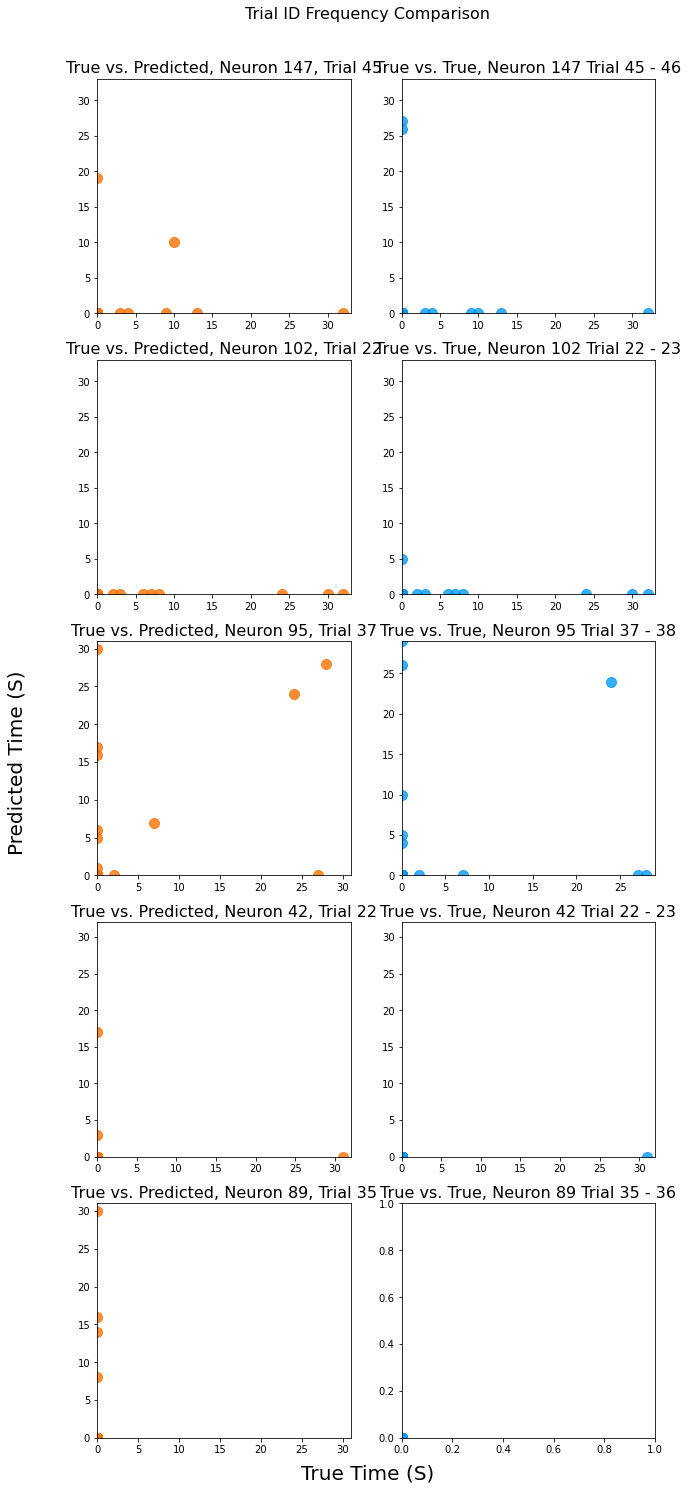

In [318]:
from utils import *

set_plot_white()

df_pred['ID'] = df_pred['ID'].astype(int)
test_data['ID'] = test_data['ID'].astype(int)

def get_id_intervals(df, n_id, intervals):
    id_intervals = np.zeros(len(intervals))
    interval_counts = df[df['ID'] == n_id].groupby(df['Interval']).size()
    id_intervals[interval_counts.index.astype(int).tolist()] = interval_counts.index.astype(int).tolist()
    return id_intervals.tolist()

rates_true, rates_pred = get_rates(test_data, ids, labels), get_rates(df_pred, ids, labels)
top_corr = calc_corr_psth(rates_true, rates_pred)

true_color = "#069AF3"
pred_color = "#F97306"
train_color = "#008000"

df_pred = df_pred[df_pred['ID'] <= max(test_data['ID'].unique())]

# neuron_ids = [i for i in range(20, 26)]
# neuron_ids = top_corr[:5]
# neuron_ids = df_pred.groupby('ID').size().nlargest(5).index
neuron_ids = np.random.choice(df_pred['ID'].unique(), size=5, replace=False)
fig, ax = plt.subplots(figsize=(10, 5 * n_trials), nrows=n_trials, ncols=2)

# neuron_ids = [i for i in range(20, 26)]
for i, n_id in enumerate(neuron_ids):
    trial = np.random.choice(df_pred['Trial'].unique())
    n_id = int(n_id)
    rate_true = get_id_intervals(test_data[test_data['Trial'] == trial], n_id, labels)
    rate_pred = get_id_intervals(df_pred[df_pred['Trial'] == trial], n_id, labels)
    rate_train = get_id_intervals(train_data[train_data['Trial'] == chosen_trial + 1], n_id, labels)

    ax[i][0].set_title(f"True vs. Predicted, Neuron {n_id}, Trial {trial}")
    ax[i][0].scatter(rate_true, rate_pred, alpha=0.8, color=pred_color)
    ax[i][0].set_xlim(0, max(rate_true + rate_pred) + 1)
    ax[i][0].set_ylim(0, max(rate_true + rate_pred) + 1)

    ax[i][1].set_title(f"True vs. True, Neuron {n_id} Trial {trial} - {trial + 1}")
    ax[i][1].scatter(rate_true, rate_train, alpha=0.8, color=true_color)
    ax[i][1].set_xlim(0, max(rate_true + rate_true) + 1)
    ax[i][1].set_ylim(0, max(rate_true + rate_true) + 1)

fig.supxlabel('True Time (S)', y=0.10)
fig.supylabel('Predicted Time (S)', x=0.00)
fig.suptitle("Trial ID Frequency Comparison", y=0.92, fontsize=16)
plt.tight_layout

23
81
13
32
34


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

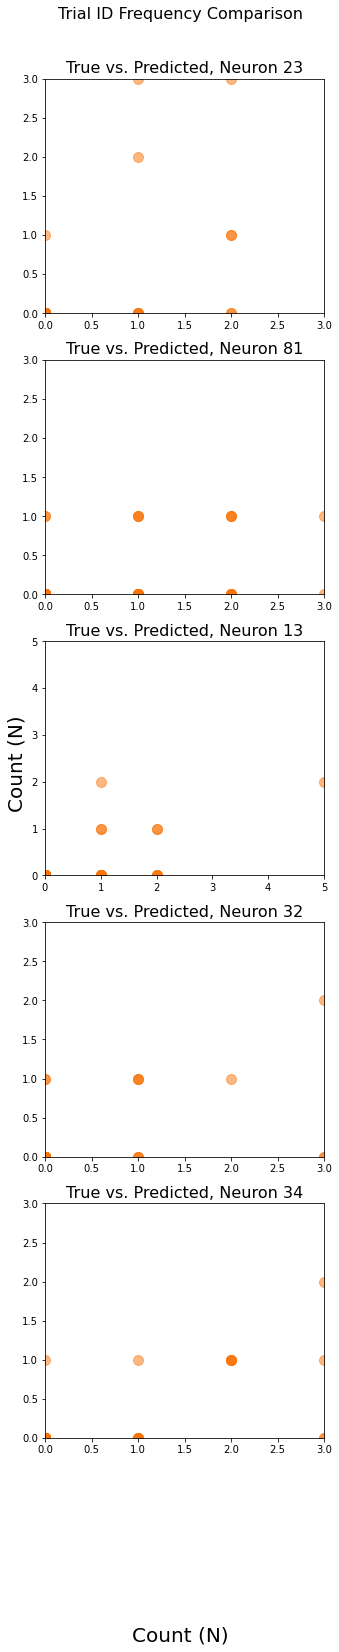

In [234]:
from utils import *

set_plot_white()

df_pred['ID'] = df_pred['ID'].astype(int)
test_data['ID'] = test_data['ID'].astype(int)

def get_id_intervals(df, n_id, intervals):
    id_intervals = np.zeros(len(intervals))
    interval_counts = df[df['ID'] == n_id].groupby(df['Interval']).size()
    id_intervals[interval_counts.index.astype(int).tolist()] = interval_counts.values
    return id_intervals.tolist()

rates_true, rates_pred = get_rates(test_data, ids, labels), get_rates(df_pred, ids, labels)
top_corr = calc_corr_psth(rates_true, rates_pred)

true_color = "#069AF3"
pred_color = "#F97306"
train_color = "#008000"

df_pred = df_pred[df_pred['ID'] <= max(test_data['ID'].unique())]

# neuron_ids = [i for i in range(20, 26)]
# neuron_ids = top_corr[:5]
neuron_ids = df_pred.groupby('ID').size().nlargest(5).index
fig, ax = plt.subplots(figsize=(5, 5 * n_trials), nrows=n_trials, ncols=1)

# neuron_ids = [i for i in range(20, 26)]
for i, n_id in enumerate(neuron_ids):
    n_id = int(n_id)
    rate_true = get_id_intervals(test_data, n_id, labels)
    rate_pred = get_id_intervals(df_pred, n_id, labels)
    # rate_train = get_freqs(train_data[train_data['Trial'] == chosen_trial + 1], n_neurons)

    ax[i].set_title(f"True vs. Predicted, Neuron {n_id}")
    ax[i].scatter(rate_true, rate_pred, alpha=0.5, color=pred_color)
    ax[i].set_xlim(0, max(rate_true + rate_pred))
    ax[i].set_ylim(0, max(rate_true + rate_pred))

fig.supxlabel('Count (N)')
fig.supylabel('Count (N)')
fig.suptitle("Trial ID Frequency Comparison", y=0.92, fontsize=16)
plt.tight_layout

In [ ]:
from utils import *
set_plot_white()

def plot_var(ax, df, variable, values):
    for value in values:
        color = color_map[value]
        data = df[df[variable] == value]
        data[variable] = data[variable].astype('str')
        ax.scatter(data['Time'], data[variable], color=color,    # c=data[variable].map(color_map),
                   marker="|", s=150)

        # ax.xaxis.set_tick_params(top='off', direction='out', width=1)
        ax.yaxis.set_tick_params(right='off', left='off', direction='out', width=1)
        
        # ax.set_ylim(0, len(values))
        xlim = int(max(df['Interval']))
        ax.set_xlim(0, xlim)
        ax.set_xticks(np.linspace(0, xlim, num=3))

        ax.tick_params(axis='y', labelsize=10) 
        ax.tick_params(axis='x', labelsize=10)       

        # ax.spines['top'].set_visible(False)
        # ax.spines['right'].set_visible(False)
        # ax.spines['left'].set_visible(False)
        ax.xaxis.set_tick_params(top='off', direction='out', width=1)
        # ax.yaxis.set_tick_params(right='off', direction='out', width=1)


df_pred['ID'] = df_pred['ID'].astype('str')
test_data['ID'] = test_data['ID'].astype('str')  

# neuron_list = list(map(str, sorted(top_corr[:6].index.tolist())))
neuron_list = list(map(str, [i for i in range(20, 25)]))

trials = test_data['Trial'].unique()
# neuron_list = sorted(top_corr[:10].index.tolist())
scale = 1
fig, ax = plt.subplots(nrows=2, ncols=len(neuron_list), figsize=(12 * scale,10 * scale))
variable = 'Trial'

color_labels = trials
rgb_values = sns.color_palette("gist_ncar_r", len(trials))
color_map = dict(zip(color_labels, rgb_values))

for n, neuron in enumerate(neuron_list):
    true_df = test_data[test_data['ID'] == neuron]
    pred_df = df_pred[df_pred['ID'] == neuron]
    ax[0][n].set_title(f'Neuron {neuron}')
    plot_var(ax[0][n], true_df, variable, trials)
    plot_var(ax[1][n], pred_df, variable, trials)

plt.setp(ax, yticklabels=trials)


ax[0][0].set_ylabel('Ground Truth')
ax[1][0].set_ylabel('Simulated')

fig.supxlabel('Time (S)')
fig.supylabel('Trials')
# fig.title('Spike Rasters')
plt.tight_layout()

plt.savefig('/Users/antonis/projects/slab/neuroformer/plots/neuron_pred_true_trials.png', dpi=300)

In [ ]:
plt.figure(figsize=(13, 13))

plt.scatter(df_pred_8_pred['Time'], df_pred_8_pred['Predicted'], color='#45b3e0', marker="|", s=100, label='Simulated')
plt.scatter(df_pred_8_true['Time'], df_pred_8_true['True'] + 0, color='#b3e045', marker="|", s=100, label=f'Trial {t_1}')
plt.scatter(df_pred_7_true['Time'], df_pred_7_true['True'] - 0, color='#e045b3', marker="|", s=100, label=f'Trial {t_2}')

# plt.yticks(np.arange(0, len(neuron_list), step=160 / len(neuron_list)))
plt.legend(loc=2, fontsize=15, title_fontsize=15)
plt.title('Spike Raster', fontsize=25)
plt.ylabel('Neuron ID', fontsize=20)
plt.xlabel('Time (s)', fontsize=20)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)

# some random data
x = np.random.randn(1000)
y = np.random.randn(1000)


def scatter_hist(x, y, ax, ax_histy, color=None):
    # no labels
    # ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    # ax.scatter(x, y)
    # bins = 250

    # now determine nice limits by hand:
    # binwidth = 0.25
    # xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    # lim = (int(xymax/binwidth) + 1) * binwidth

    # bins = np.arange(-lim, lim + binwidth, binwidth)
    # ax_histx.hist(x, bins=bins)
    ax_hist = sns.distplot(y,  hist=False, ax=ax_histy, vertical=True, color=color) # (x, y, bins=10, orientation='horizontal')
    ax_hist.set(xlabel=None)

    # sns.distplot(top_corr, hist=False, ax=ax_histy, vertical=True)


In [ ]:
df_pred = pd.read_csv("OneCombo3/inference/model_weighted_shuffle:True_perceiver_2.0_dt:0.05_eos_8_8_256.csv").iloc[:, 1:]
# df_pred['Trial'] = test_data['Trial']
df_pred.rename({'id':'ID', 'trial':'Trial', 'interval':'Interval', 'time':'Time'}, axis=1, inplace=True)
df_pred.head()


In [ ]:
by_label

In [ ]:
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerBase

class HandlerColormap(HandlerBase):
    def __init__(self, cmap, num_stripes=8, **kw):
        HandlerBase.__init__(self, **kw)
        self.cmap = cmap
        self.num_stripes = num_stripes
    def create_artists(self, legend, orig_handle, 
                       xdescent, ydescent, width, height, fontsize, trans):
        stripes = []
        for i in range(self.num_stripes):
            s = Rectangle([xdescent + i * width / self.num_stripes, ydescent], 
                          width / self.num_stripes, 
                          height, 
                          fc=self.cmap((2 * i + 1) / (2 * self.num_stripes)), 
                          transform=trans)
            stripes.append(s)
        return stripes


In [ ]:
df_pred['ID'] = df_pred['ID'].astype('int')
test_data['ID'] = test_data['ID'].astype('int') 

ax = fig.add_axes(rect_scatter)
# ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
# start with a square Figure
fig = plt.figure(figsize=(15, 15))

ax = fig.add_axes(rect_scatter)
# ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

c_map_true = sns.color_palette("Blues", len(trials))
c_map_pred = sns.color_palette("YlOrBr", len(trials))
cmaps = [sns.color_palette("Blues", as_cmap=True), sns.color_palette("YlOrBr", as_cmap=True)]
true_color = 'blue'   # "#069AF3"
pred_color = 'orange'   # "#F97306"

for n, trial in enumerate(trials):
    trial_prev = trials[n - 1] if n > 0 else trials[n + 1]
    true_prev = test_data[test_data['Trial'] == trial_prev].reset_index(drop=True)
    true = test_data[test_data['Trial'] == trial].reset_index(drop=True)
    pred = df_pred[df_pred['Trial'] == trial].reset_index(drop=True)
    rates_true_prev, rates_true, rates_pred = get_rates_trial(true_prev, labels), get_rates_trial(true, labels), get_rates_trial(pred, labels)
    
    corr_trials_true = calc_corr_psth(rates_true, rates_true_prev)
    corr_trials_pred = calc_corr_psth(rates_true, rates_pred)
    
    scatter_hist(np.array(corr_trials_true.index), corr_trials_true, ax, ax_histy, color=c_map_true[n])
    scatter_hist(np.array(corr_trials_pred.index), corr_trials_pred, ax, ax_histy, color=c_map_pred[n])
    ax.grid(lw=0.8, alpha=0.7, color='gray')
    ax.scatter(corr_trials_true.index, corr_trials_true, label=f'Intra-Trial Ground Truth', alpha=0.8, color=c_map_true[n])
    ax.scatter(corr_trials_pred.index, corr_trials_pred, label=f'Simulated vs. Ground Truth', alpha=0.8, color=c_map_pred[n])
    plt.legend()


ax.set_title('Pair-wise Correlation Between Trials', fontsize=25)
ax.set_xlabel('Neuron ID (n)', fontsize=20)
ax.set_ylabel('Pearson Correlation (p)', fontsize=20)
ax.set_ylim(-0.2, 1.2)

handles, labs = ax.get_legend_handles_labels()
by_label = dict(zip(labs, handles))
cmap_handles = [Rectangle((0, 0), 1, 1) for _ in cmaps]
# cmaps = [plt.cm.spring, plt.cm.winter] 
handler_map = dict(zip(cmap_handles, 
                       [HandlerColormap(cm, num_stripes=8) for cm in cmaps]))
ax.legend(handles=cmap_handles, labels=by_label.keys(), handler_map=handler_map, fontsize=20)

# ax.legend(fontsize=20, title_fontsize=20)
plt.tight_layout()
plt.savefig("/Users/antonis/projects/slab/neuroformer/plots/psth_corr_trials.png", dpi=300)

In [ ]:
corr_trials.mean()

In [ ]:
means

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# construct some data like what you have:
x = np.random.randn(100, 8)
mins = x.min(0)
maxes = x.max(0)
means = x.mean(0)
std = x.std(0)

# create stacked errorbars:
plt.errorbar(np.arange(8), means, std, fmt='ok', lw=3)
# plt.errorbar(np.arange(8), means, [means - mins, maxes - means],
#              fmt='.k', ecolor='gray', lw=1)
plt.xlim(-1, 8)

In [ ]:
true_color = "#069AF3"
pred_color = "#F97306"

fig, ax = plt.subplots()

data_boxplot_true = []
data_boxplot_pred = []
for n, trial in enumerate(trials):
    trial_prev = trials[n - 1] if n > 0 else trials[n + 1]
    true_prev = test_data[test_data['Trial'] == trial_prev].reset_index(drop=True)
    true = test_data[test_data['Trial'] == trial].reset_index(drop=True)
    pred = df_pred[df_pred['Trial'] == trial].reset_index(drop=True)
    rates_true_prev, rates_true, rates_pred = get_rates_trial(true_prev, labels), get_rates_trial(true, labels), get_rates_trial(pred, labels)
    
    corr_trials_true = calc_corr_psth(rates_true, rates_true_prev)
    corr_trials_pred = calc_corr_psth(rates_true, rates_pred)

    data_boxplot_true.append(np.array(corr_trials_true).flatten())
    data_boxplot_pred.append(np.array(corr_trials_pred).flatten())

    def plot_error_bar(x, n, color):
        mins = x.min()
        maxes = x.max()
        means = x.mean()
        std = x.std()

        # plt.errorbar(n, means, std, fmt='ok', lw=3)
        # plt.errorbar(n, means, [means - mins, maxes - means],
        #             fmt='.k', ecolor='gray', lw=1)
        # plt.xlim(-1, 8)
        
        green_diamond = dict(markerfacecolor=color, marker='o')
        # fig3, ax3 = plt.subplots()
        # ax3.set_title('Changed Outlier Symbols')
        ax.boxplot(x, flierprops=green_diamond)
    
    plot_error_bar(corr_trials_true, n, true_color)
    plot_error_bar(corr_trials_pred, n, pred_color)


In [ ]:
random_dists = ['Normal(1, 1)', 'Lognormal(1, 1)', 'Exp(1)', 'Gumbel(6, 4)',
                'Triangular(2, 9, 11)']
N = 500

norm = np.random.normal(1, 1, N)
logn = np.random.lognormal(1, 1, N)
expo = np.random.exponential(1, N)
gumb = np.random.gumbel(6, 4, N)
tria = np.random.triangular(2, 9, 11, N)

# Generate some random indices that we'll use to resample the original data
# arrays. For code brevity, just use the same random indices for each array
bootstrap_indices = np.random.randint(0, N, N)
data = [
    norm, norm[bootstrap_indices],
    logn, logn[bootstrap_indices],
    expo, expo[bootstrap_indices],
    gumb, gumb[bootstrap_indices],
    tria, tria[bootstrap_indices],
]


In [ ]:
data[0].shape

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=len(neuron_list), figsize=(12 * scale,10 * scale))

In [ ]:
by_label.values()

In [ ]:
from matplotlib.patches import Polygon

data = data_boxplot_true

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))
# fig.canvas.manager.set_window_title('A Boxplot Example')
fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

def fancy_boxplot(ax1, data, color):
    bp = ax1.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['fliers'], color='red', marker='+')

    # Add a horizontal grid to the plot, but make it very light in color
    # so we can use it for reading data values but not be distracting
    ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                alpha=0.5)

    # ax1.set(
    #     axisbelow=True,  # Hide the grid behind plot objects
    #     title='Comparison of IID Bootstrap Resampling Across Five Distributions',
    #     xlabel='Distribution',
    #     ylabel='Value',
    # )

    # Now fill the boxes with desired colors
    # box_colors = ['darkkhaki', 'royalblue']
    # box_colors = sns.dark_palette("#69d", len(data), reverse=True)
    box_colors = [color]
    num_boxes = len(data)
    medians = np.empty(num_boxes)
    for i in range(num_boxes):
        box = bp['boxes'][i]
        box_x = []
        box_y = []
        for j in range(5):
            box_x.append(box.get_xdata()[j])
            box_y.append(box.get_ydata()[j])
        box_coords = np.column_stack([box_x, box_y])
        # Alternate between Dark Khaki and Royal Blue
        ax1.add_patch(Polygon(box_coords, facecolor=box_colors[0]))
        # Now draw the median lines back over what we just filled in
        med = bp['medians'][i]
        median_x = []
        median_y = []
        for j in range(2):
            median_x.append(med.get_xdata()[j])
            median_y.append(med.get_ydata()[j])
            ax1.plot(median_x, median_y, 'k')
        medians[i] = median_y[0]
        # Finally, overplot the sample averages, with horizontal alignment
        # in the center of each box
        ax1.plot(np.average(med.get_xdata()), np.average(data[i]),
                color='w', marker='*', markeredgecolor='k')

    # Set the axes ranges and axes labels
    # ax1.set_xlim(0.5, num_boxes + 0.5)
    # top = 40
    # bottom = -5
    # ax1.set_ylim(bottom, top)
    # ax1.set_xticklabels(np.repeat(random_dists, 2),
    #                     rotation=45, fontsize=8)

    # Due to the Y-axis scale being different across samples, it can be
    # hard to compare differences in medians across the samples. Add upper
    # X-axis tick labels with the sample medians to aid in comparison
    # (just use two decimal places of precision)
    pos = np.arange(num_boxes) + 1
    upper_labels = [str(round(s, 2)) for s in medians]
    weights = ['bold', 'semibold']
    for tick, label in zip(range(num_boxes), ax1.get_xticklabels()):
        k = tick % 2
        ax1.text(pos[tick], .95, upper_labels[tick],
                transform=ax1.get_xaxis_transform(),
                horizontalalignment='center', size='x-small',
                weight=weights[k], color=box_colors[0])

fancy_boxplot(ax[0], data_boxplot_true, true_color)
# ax[0].set_ylabel('Inter-Trial Ground Truth')
fancy_boxplot(ax[1], data_boxplot_pred, pred_color)
# ax[1].set_ylabel('Ground Truth vs. Prediction')

fig.supxlabel('Trials')
fig.supylabel('Pearson Correlation (P)')

# # Finally, add a basic legend
# t_size = 20
# fig.text(0.80, 0.08, f'Inter-Trial Ground Truth',
#          backgroundcolor=true_color, color='black', weight='roman',
#          size=t_size)
# fig.text(0.80, 0.045, 'Ground Truth vs. Simulation',
#          backgroundcolor=pred_color,
#          color='white', weight='roman', size=t_size)

# fig.legend(by_label.values(), by_label.keys(), fontsize=10)
# leg = plt.get_legend()
# leg.legendHandles[0].set_color(true_color)
# leg.legendHandles[1].set_color(pred_color)
fig.suptitle('Inter-Neuron Correlation Across Trials')
plt.tight_layout()
plt.savefig("/Users/antonis/projects/slab/neuroformer/plots/boxplot_interneuron_correlation.png", dpi=300)

In [161]:
df_1

,Time,ID,Trial,Interval,Interval_dt
6019,0.015,16,15,0.5,0.05
6020,0.110,71,15,0.5,0.15
6021,0.128,23,15,0.5,0.15
6022,0.158,13,15,0.5,0.20
6023,0.190,157,15,0.5,0.20
...,...,...,...,...,...
6311,31.753,95,15,32.0,0.30
6312,31.767,95,15,32.0,0.30
6313,31.787,53,15,32.0,0.30
6314,31.852,155,15,32.0,0.40


NameError: name 'scatter_hist' is not defined

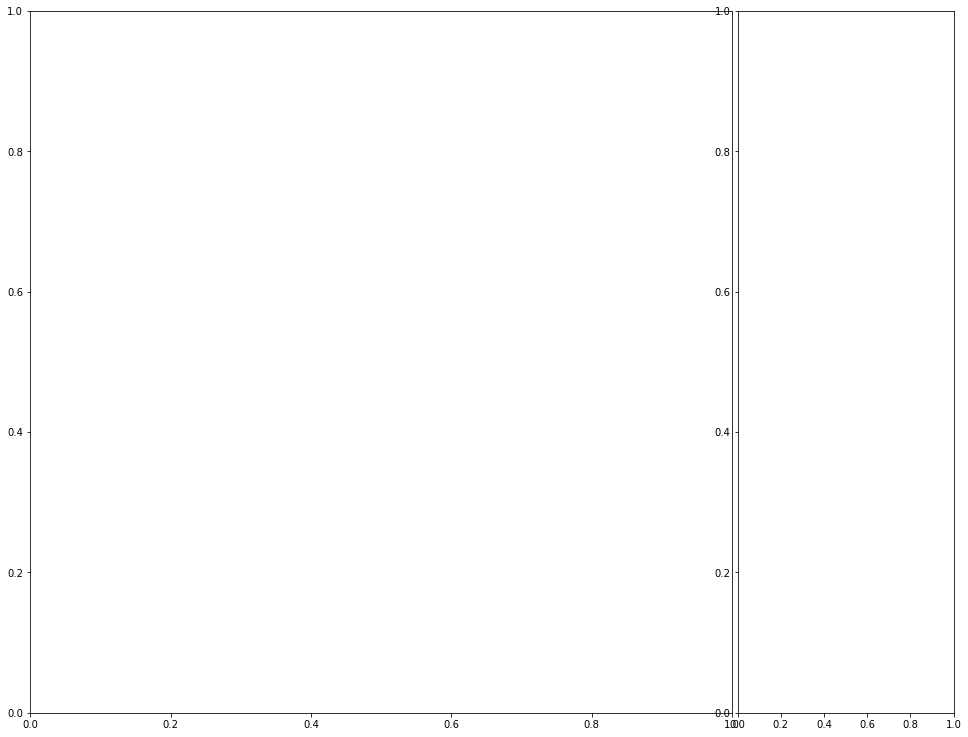

In [154]:
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


t_1 = 25
t_2 = 35

rates_trial_8 = get_rates_trial(df[df['Trial'] == t_1].reset_index(drop=True), labels)
rates_trial_1 = get_rates_trial(df[df['Trial'] == t_2].reset_index(drop=True), labels)
corr_trials = calc_corr_psth(rates_trial_1, rates_trial_8)


rect_scatter = [left, bottom, width, height]
# rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(15, 15))

ax = fig.add_axes(rect_scatter)
# ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(np.array(corr_trials.index), corr_trials, ax, ax_histy)
scatter_hist(np.array(top_corr.index), top_corr, ax, ax_histy)
ax.grid(lw=0.8, alpha=0.7, color='gray')
ax.scatter(corr_trials.index, corr_trials, label=f'Trial {t_1} vs. 1', alpha=0.4)
ax.scatter(top_corr.index, top_corr, label=f'Trial {t_1} vs. Pred', alpha=0.5)
ax.set_title('Pair-wise Correlation Between Trials', fontsize=25)
ax.set_xlabel('Neuron ID', fontsize=20)
ax.set_ylim(-0.1, 0.6)
plt.ylabel('Pearson Correlation (p)')
ax.legend(fontsize=20, title_fontsize=20)
plt.show()

In [229]:
''' Inter trial Event '''

def get_inter_trial_event(df):
    df_inter_trial = np.array(df['Time'][1:]) - np.array(df['Time'][:-1])
    return df_inter_trial

len_event = min(len(df_1), len(df_2)) - 1
it_event_1 = get_inter_trial_event(df_1)[:len_event]
it_event_2 = get_inter_trial_event(df_2)[:len_event]

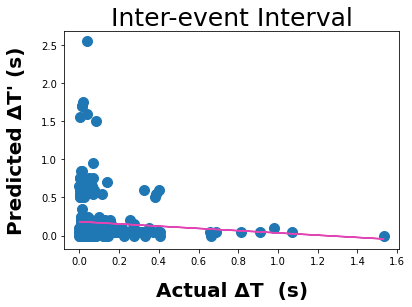

In [232]:
it_event_fit = np.polyfit(it_event_1, it_event_2, 1)
plt.title('Inter-event Interval', fontsize=25)
plt.xlabel('Actual ΔT  (s)', fontsize=20)
plt.ylabel("Predicted ΔT' (s)", fontsize=20)
plt.scatter(it_event_1, it_event_2)
plt.plot(it_event_1, it_event_fit[0] * it_event_1 + it_event_fit[1], color='#e045b3')

In [209]:
df_1 = test_data[test_data['Trial'] == 2]
df_2 = df_pred = df_pred[(df_pred['Interval'].isin(test_data['Interval'].unique())) & (df_pred['Trial'] == 2)]

In [210]:
len(df_2['Interval'].unique())

56

In [211]:
len(df_1['Interval'].unique())

56

In [212]:
df_1 = 

SyntaxError: invalid syntax (<ipython-input-212-ab7acb84e7a4>, line 1)

In [213]:
df_pred = df_pred[df_pred['Interval'].isin(test_data['Interval'].unique())]

In [214]:
common_ids = set(df_1['ID'].unique()) & set(df_2['ID'].unique())

In [215]:
df_1_mean_spikes

ID   Trial
0    2        1
     5        1
     22       4
     37       1
     45       4
             ..
164  17       8
     35       3
     37       1
     55       5
     57       5
Name: Time, Length: 1337, dtype: int64

In [216]:
''' Trial-Averaged Spike Number '''

df_1_mean_spikes = df_1.groupby(['ID', 'Trial']).count().loc[common_ids].sort_index()['Time']
df_2_mean_spikes = df_2.groupby(['ID', 'Trial']).count().loc[common_ids].sort_index()['Time']

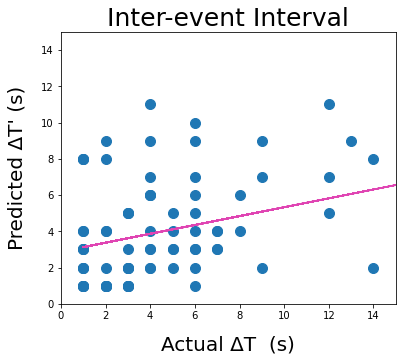

In [219]:
mean_spike_fit = np.polyfit(df_1_mean_spikes, df_2_mean_spikes, 1)
plt.figure(figsize=(6, 5))
plt.title('Inter-event Interval', fontsize=25)
plt.xlabel('Actual ΔT  (s)', fontsize=20)
plt.ylabel("Predicted ΔT' (s)", fontsize=20)
plt.ylim(0, 15)
plt.xlim(0, 15)
plt.scatter(df_1_mean_spikes, df_2_mean_spikes)
plt.plot(df_1_mean_spikes, mean_spike_fit[0] * df_1_mean_spikes + mean_spike_fit[1], color='#e045b3')

In [220]:
df_10_20 = df[(df['Trial'] < 20) & (df['Trial'] >= 0)].groupby(['ID']).count()

In [221]:
df_10_20 = df[(df['Trial'] < 20) & (df['Trial'] >= 10) & (df['ID'] == 20)]
df_0_10 = df[(df['Trial'] < 10) & (df['ID'] == 20)]

In [222]:
df_n30 = df[(df['Trial'] < 30) & (df['ID'] == 20)]
df_30n = df[(df['Trial'] >= 30) & (df['ID'] == 20)]

def get_event_time_std(df):
    time_std = []
    for trial in df['Trial'].unique():
        time_std.append(df['Time'][df['Trial'] == trial].std(ddof=0))
    return np.array(time_std)

time_std_1 = get_event_time_std(df_n30)
time_std_2 = get_event_time_std(df_30n)
min_len_time_std = min(len(time_std_1), len(time_std_2))
time_std_1 = time_std_1[:min_len_time_std]
time_std_2 = time_std_2[:min_len_time_std]


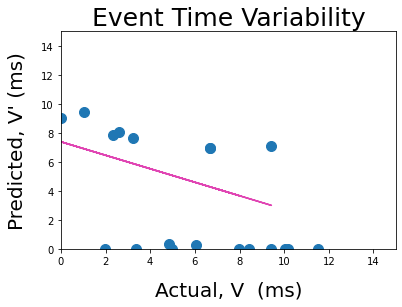

In [223]:
''' Event Time Variability '''

time_std_fit = np.polyfit(time_std_1, time_std_2, 1)
plt.title('Event Time Variability', fontsize=25)
plt.xlabel('Actual, V  (ms)', fontsize=20)
plt.ylabel("Predicted, V' (ms)", fontsize=20)
plt.ylim(0, 15)
plt.xlim(0, 15)
plt.scatter(time_std_2, time_std_1)
plt.plot(time_std_1, time_std_fit[0] * time_std_1 + time_std_fit[1], color='#e045b3')

In [224]:
''' Spike Number Variability '''

rates = get_rates(df, df['ID'].unique(), labels)
rates = pd.DataFrame(rates)

In [225]:
r1 = get_rates(df[(df['Trial'] == 1)], [20], labels)
r2 = get_rates(df[(df['Trial'] == 2)], [20], labels)

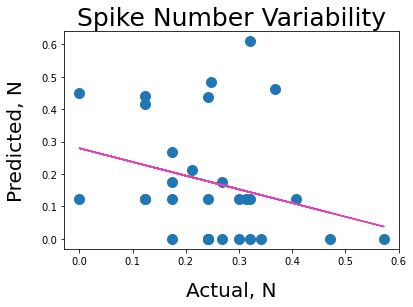

In [226]:
df_10_20 = df[(df['Trial'] < 31)]
df_0_10 = df[(df['Trial'] >= 31)]

def get_spike_number(df, id):
    spike_number = dict()
    for trial in df['Trial'].unique():
        n = len(df[(df['Trial'] == trial) & (df['ID'] == id)])
        spike_number[trial] = n if n > 0 else 0
    return np.array(pd.DataFrame(spike_number, index=[0])).flatten()

def get_spike_std(df, id, intervals):
    rates = dict()
    for trial in df['Trial'].unique():
        rate_trial = get_rates(df[(df['Trial'] == trial)], id, intervals)
        # std = pd.DataFrame(rates).std(ddof=0)
        rates[trial] = list(rate_trial.values())[0]
    # return rates
    rates = pd.DataFrame(rates)
    # return rates
    return rates.std(axis=0, ddof=0)

ids = [20]      
spike_number_1 = get_spike_std(df_0_10, ids, labels)
spike_number_2 = get_spike_std(df_10_20, ids, labels)

# idn = 20
# spike_number_1 = get_spike_number(df_0_10, idn)
# spike_number_2 = get_spike_number(df_10_20, idn)

''' Spike Number Variability '''

spike_number_fit = np.polyfit(spike_number_1, spike_number_2, 1)
plt.title('Spike Number Variability', fontsize=25)
plt.xlabel('Actual, N', fontsize=20)
plt.ylabel("Predicted, N", fontsize=20)
# plt.ylim(0, 15)
# plt.xlim(0, 15)
plt.scatter(spike_number_1, spike_number_2)
plt.plot(spike_number_1, spike_number_fit[0] * spike_number_1 + spike_number_fit[1], color='#e045b3')


In [227]:
from utils import set_plot_params, set_plot_white

set_plot_params()
set_plot_white()

In [228]:
def custom_lineplot(ax, x, y, error, xlims, ylims, color='red'):
    """Customized line plot with error bars."""
    
    ax.errorbar(x, y, yerr=error, color=color, ls='--', marker='o', capsize=5, capthick=1, ecolor='black')
    
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
    return ax

def custom_scatterplot(ax, x, y, error, xlims, ylims, color='green', markerscale=100):
    """Customized scatter plot where marker size is proportional to error measure."""
    
    markersize = error * markerscale
    
    ax.scatter(x, y, color=color, marker='o', s=markersize, alpha=0.5)
    
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
    return ax


def stylize_axes(ax, xticks, yticks, xticklabels, yticklabels):
    """Customize axes spines, title, labels, ticks, and ticklabels."""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.xaxis.set_tick_params(top='off', direction='out', width=1)
    ax.yaxis.set_tick_params(right='off', direction='out', width=1)
    
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)

    ax.set_xlim(ax.get_xlim()[0] - ax.get_xlim()[1]*0.05, ax.get_xlim()[1]*1.05)
    ax.set_ylim(ax.get_ylim()[0] - ax.get_ylim()[1]*0.05, ax.get_ylim()[1]*1.05)

    ax.tick_params(top="off", right="off")

In [148]:
def get_lims(arr1, arr2):
    return math.ceil(max([np.max(arr1), np.max(arr1)]))

In [149]:
def plot_scatter_line(ax, x, y, title, xlabel, ylabel, color='red'):
    lims = get_lims(x, y)
    ax.set_xlim(0, lims)
    ax.set_ylim(0, lims)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.scatter(x, y, color='blue', marker='o', s=100, alpha=0.5)
    reg_line = np.polyfit(x, y, 1)
    ax.plot(x, reg_line[0] * x + reg_line[1], color=color)
    return ax


NameError: name 'it_event_1' is not defined

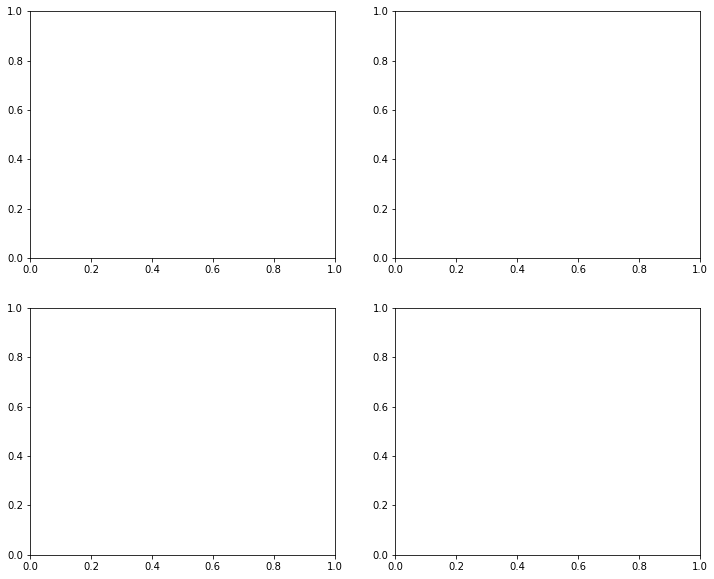

In [150]:
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['lines.markersize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10    
plt.rcParams['axes.labelweight'] = 'normal'

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

plot_scatter_line(ax[0][0], it_event_1, it_event_2, 'Spike Number Mean', 'Actual, N', 'Predicted, N\'', color='red')
plot_scatter_line(ax[0][1], df_1_mean_spikes, df_2_mean_spikes, 'Inter-event Interval', 'Actual ΔT  (s)', 'Predicted ΔT\' (s)', color='red')
plot_scatter_line(ax[1][0], time_std_1, time_std_2, 'Event Time Variability', 'Actual, V  (ms)', 'Predicted, V\' (ms)', color='red')
plot_scatter_line(ax[1][1], spike_number_1, spike_number_2, 'Spike Number Variability', 'Actual, S', 'Predicted, S\'', color='red')

for i, axes in enumerate(ax.flat):
    # Customize y ticks on a per-axes basis
    xticks = np.linspace(axes.get_xlim()[0], axes.get_xlim()[1], 5)
    xticklabels = xticks
    yticks = np.linspace(axes.get_ylim()[0], axes.get_ylim()[1], 5)
    yticklabels = yticks
    stylize_axes(axes, xticks, yticks, xticklabels, yticklabels)

fig.tight_layout()

fig.savefig('Statistics_real.png', dpi=300, bbox_inches='tight', transparent=False)